In [ ]:
''' This version hitches PIGEBaQ onto the permutation method '''

import pandas as pd

df = pd.read_excel("Skills.xlsx")
#print(df.head())

#Lets remove the importance values:

df2 = df.loc[df["Scale Name"] == "Level"]
df2.reset_index(drop = True, inplace = True)
#print(df2.head())

#Lets now remove the irrelevent columns:

df3 = df2.drop(columns = ["Scale ID","Scale Name","N","Recommend Suppress","Not Relevant","Date","Domain Source"])
print(df3.head())

#NOTE that we have ignored the suppress recomendations, we shall continue with this for now but will need to address this later


In [ ]:
#Lets now discover a bit about our data set:

df3.info()

#We note that there are some occupations for which the standard error and bound values are missing. Lets supress these for now:

df3.drop(columns = ["Standard Error","Lower CI Bound","Upper CI Bound"],inplace = True)
print(df3.head())

In [ ]:
#I shall implement the drop_duplicates method:

df4 = df3[["O*NET-SOC Code","Title"]]
df4.drop_duplicates(inplace=True)
df4.reset_index(drop = True, inplace = True)
#print(df4.head())

#We now need to add the variables. Begin by adding empty columns to the dataframe:

n_jobs = len(set((df3["Title"])))
n_variables = len(set((df3["Element Name"])))

for i in range(n_jobs):
    df4[df3["Element Name"][i]] = ""

#print(df4.head())
#Now we need to fill these columns:

x = df3.loc[df3["Title"] == "Chief Executives"]
y = x["Data Value"]

for i in range(n_variables):
    df4[df4.columns[2+i]][0] = y[i]
    
#We now need to do this procedure for every job:

for j in range(n_jobs):
    x = df3.loc[df3["Title"] == df4.iloc[j,1]]
    y = x["Data Value"]
    y.reset_index(drop = True, inplace = True)
    for i in range(n_variables):
        df4[df4.columns[2+i]][j] = y[i]


In [ ]:
print(df4.head())
print(df4.tail())

### We now have the skills dataframe just as we want it!

In [ ]:
#Lets understand our data a bit:

df4.describe()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
hist = df4.iloc[:,20].hist(bins=20)

#We can inspect the histogram of any variable we want

### Let's now  import another dataframe with autovalues

In [ ]:
df5 = pd.read_excel("US_data_email.xls")
df5 = df5[["Occupation Name","BLS codes","Training set automatable labels"]]
print(df5.head())

In [ ]:
df5.info()

In [ ]:
#Lets define a function so that we can make occupation ID's consistent:

def title_set(my_string):
    my_list = []
    my_list[:0] = my_string
    my_list.remove("_")
    my_list.append(".00")
    my_output = "".join(my_list)
    return my_output

#print(title_set("45-4023_"))

df5.iloc[:,1] = df5.iloc[:,1].apply(title_set)
print(df5.head())
df5.info()

In [ ]:
#Lets now concatenate the auto labels to our 1st dataframe:
import numpy as np
df4["Auto label value"] = np.nan
for i in list(df5["BLS codes"]):
    df4.loc[df4["O*NET-SOC Code"] == i,"Auto label value"] = list(df5.loc[df5["BLS codes"] == i,"Training set automatable labels"])

In [ ]:
df4.info()

#Note - the auto value count is supposedly 330 non-null, even though it should be 70. After creating a csv from the dataframe,
#I found that there were 70 non-null as expected. Worth bringing up with Mike.

In [ ]:
df4.to_csv("test.csv",index=False)

### START FROM HERE

In [133]:
import numpy as np
import pandas as pd

df4 = pd.read_csv("ControlData1.csv")
df4.head()

,Feature1,Feature2,Feature3,Feature4,Output
0,0.418287,0.106315,0.367642,0.609699,0.0
1,0.353350,0.277904,-0.357989,0.899122,0.0
2,0.120200,0.397125,-0.023316,0.789937,0.0
3,0.395666,-0.163691,0.999948,0.734246,0.0
4,0.230537,0.238473,0.186635,0.045195,0.0


### We now have a dataset which encompass jobs titles, SOC codes, skill levels and hand picked auto labels

### Lets now split and standardize the data:

In [ ]:
#To prevent information about the distribution of the test set leaking into the model, we shall first form a training set
# and form a scaler operator from this, and then apply this to both training and test sets.


In [134]:
#Lets now create a training set which includes only the jobs for which we have hand picked auto values:

training_set = df4.dropna(axis=0,how="any")
training_set.reset_index(drop = True, inplace=True)
#print(training_set.head())
training_set.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Feature1  200 non-null    float64
 1   Feature2  200 non-null    float64
 2   Feature3  200 non-null    float64
 3   Feature4  200 non-null    float64
 4   Output    200 non-null    float64
dtypes: float64(5)
memory usage: 7.9 KB


In [135]:
#Lets apply stratified sampling on this set to create a training and test set
#Code taken from Hands on Machine Learning book

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index, test_index in split.split(training_set,training_set["Output"]):
    strat_train_set = training_set.loc[train_index]
    strat_test_set = training_set.loc[test_index]


In [136]:
strat_train_set.reset_index(drop=True,inplace=True)
strat_test_set.reset_index(drop=True,inplace=True)

In [137]:
strat_train_set["Output"].value_counts()/len(strat_train_set)

0.0    0.5
1.0    0.5
Name: Output, dtype: float64

In [138]:
#Now that we have our training set, lets create a standardiser for it:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True,with_std=True)
scaler.fit(strat_train_set.iloc[:,0:4])
scaled_training_values = scaler.transform(strat_train_set.iloc[:,0:4])
scaled_test_values = scaler.transform(strat_test_set.iloc[:,0:4])
scaled_train_set = strat_train_set.copy()
scaled_test_set = strat_test_set.copy()
#print(strat_train_set.head())

In [139]:
temporary = pd.DataFrame(data=scaled_training_values)
temporary2 = pd.DataFrame(data=scaled_test_values) #we create temporary data frames from the numpy arrays we've just created
#print(temporary)
for i in range(0,4):
    scaled_train_set[scaled_train_set.columns[i]] = temporary[temporary.columns[i]]
    scaled_test_set[scaled_test_set.columns[i]] = temporary2[temporary2.columns[i]]

#print(scaled_test_set.head())

In [140]:
''' We shall also create a standardized set for ALL of the training data '''

scaler2 = StandardScaler(with_mean=True,with_std=True)
scaler2.fit(strat_train_set.iloc[:,0:4])
scaled_total_values = scaler2.transform(training_set.iloc[:,0:4])
scaled_total_set = training_set.copy()

temporary3 = pd.DataFrame(data=scaled_total_values)
for i in range(0,4):
    scaled_total_set[scaled_total_set.columns[i]] = temporary3[temporary3.columns[i]]
    

In [141]:
print(scaled_train_set.head())
print(scaled_test_set.head())
print(scaled_total_set.head())

   Feature1  Feature2  Feature3  Feature4  Output
0 -1.525631 -1.383735 -0.260900 -0.162168     0.0
1  0.468055  0.112434  0.678927  1.389194     1.0
2 -1.540588 -0.443355  0.823097 -1.557709     0.0
3  0.626085  0.545235  0.042940  1.150382     1.0
4  1.119117  0.679486 -0.675603 -1.038366     1.0
   Feature1  Feature2  Feature3  Feature4  Output
0 -0.921259 -1.062053 -0.203980 -0.096627     0.0
1  0.766802 -0.655023  0.974597  1.416129     1.0
2  1.476870  0.476743  0.115846 -0.608097     1.0
3  0.585031  1.298365  2.235713 -1.159922     1.0
4 -0.516725 -0.443154 -0.545677  1.745898     0.0
   Feature1  Feature2  Feature3  Feature4  Output
0 -0.235739 -1.079865 -0.216082  0.471298     0.0
1 -0.460010 -0.610156 -1.497311  1.454110     0.0
2 -1.265228 -0.283802 -0.906387  1.083343     0.0
3 -0.313863 -1.818978  0.900363  0.894231     0.0
4 -0.884161 -0.718096 -0.535683 -1.445627     0.0


In [102]:
scaled_train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Feature1  160 non-null    float64
 1   Feature2  160 non-null    float64
 2   Feature3  160 non-null    float64
 3   Feature4  160 non-null    float64
 4   Output    160 non-null    float64
dtypes: float64(5)
memory usage: 6.4 KB


In [131]:
scaled_total_set.to_csv("PIGEBAQ_testset.csv",index=False)

### We now have a fully scaled training and test set!

### We can now perform Principal Component Analysis

In [ ]:
#We begin by creating a centred training set:

X = strat_train_set.drop(["Title","O*NET-SOC Code"],axis=1)

#We now use the Scikit learn toolkit to visualise how the explained variance ratio changes with no. dimensions:

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
dim = range(len(X.columns))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.array(dim),np.array(cumsum))

In [ ]:
#Having visualized the effect of dimensionality, we can implement this to our dataset:

pca2 = PCA(n_components=0.95)
X_reduced = pca2.fit_transform(X)
print(X_reduced[1])


### We shall now fit a GP classifier to the unreduced dataset:

In [142]:
#Begin by creating numpy arrays for our input X and output Y:

#X = np.array([scaled_train_set.iloc[:,0:4]])
#Y = np.array([scaled_train_set.iloc[:,4]])
X = np.array([scaled_total_set.iloc[:,0:4]])
Y = np.array([scaled_total_set.iloc[:,4]])
#X = np.transpose(X)
#Y = np.transpose(Y)


X = np.reshape(X,(200,4)) #Reshape to go from 3d matrix to 2d
Y = np.reshape(Y,(200,1)) # ^

#Now generate a kernel:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
import GPy

kernel = GPy.kern.RBF(input_dim=4, variance=100., lengthscale=100.)
m_gpy = GPy.models.GPClassification(X,Y,kernel)
m_gpy.optimize(messages=True)
#m_gpy.optimize_restarts(num_restarts = 10)


In [104]:
#We shall request values for the variance and lengthscale:

m_var = input("What is the rbf.variance?")
m_length = input("What is the rbf.lengthscale?")

m_var = float(m_var)
m_length = float(m_length)

What is the rbf.variance?7.85
What is the rbf.lengthscale?5.40


In [105]:
#Instantiate this model in scikit learn


sci_kernel = m_var * RBF(m_length)
gpc = GaussianProcessClassifier(kernel=sci_kernel,optimizer=None).fit(X, Y)

 C:\Users\jacob\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


### Lets now apply k-fold cross validation on the model:

In [106]:
X_train = np.array(scaled_train_set.iloc[:,0:4])
#X_train = np.transpose(X_train)
y_train = np.array(scaled_train_set.iloc[:,4])
#y_train = np.transpose(y_train)

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)


for train_index, test_index in skfolds.split(X_train,y_train):
    clone_gpc = clone(gpc)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]
    
    clone_gpc.fit(X_train_folds,y_train_folds)
    y_pred = clone_gpc.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))
    

1.0
0.96875
1.0
0.96875
0.96875


### What about an F1 score?

In [107]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

y_train_pred = cross_val_predict(gpc,X_train,y_train,cv=5)
f1_score(y_train,y_train_pred)

0.9813664596273292

### And how about an AUC value?

In [108]:
from sklearn.metrics import roc_auc_score

def calc_AUC(gpc,X_train,y_train):
    y_probas = cross_val_predict(gpc,X_train,y_train,cv=5,method="predict_proba")
    y_scores = y_probas[:,1]
    return roc_auc_score(y_train,y_scores)

calc_AUC(gpc,X_train,y_train)

0.99828125

### And a log-likelihood?

In [109]:
gpc.log_marginal_likelihood(theta=None, eval_gradient=False, clone_kernel=True)

-35.18718167696032

### It is worth using the model to predict values for the test set to ensure it is working as I want it to:

In [110]:
X_test = np.array(scaled_test_set.iloc[:,0:4])
y_test = np.array(scaled_test_set.iloc[:,4])

y_pred = gpc.predict(X_test)

In [111]:
print(y_test)
print(y_pred)

[0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [112]:
gpc.predict_proba(X_test)

array([[0.95778469, 0.04221531],
       [0.27236611, 0.72763389],
       [0.02578567, 0.97421433],
       [0.03023506, 0.96976494],
       [0.88956533, 0.11043467],
       [0.03906675, 0.96093325],
       [0.9496806 , 0.0503194 ],
       [0.14562705, 0.85437295],
       [0.2577282 , 0.7422718 ],
       [0.87227011, 0.12772989],
       [0.23292703, 0.76707297],
       [0.11116295, 0.88883705],
       [0.92294662, 0.07705338],
       [0.03426014, 0.96573986],
       [0.96562843, 0.03437157],
       [0.91972138, 0.08027862],
       [0.03917346, 0.96082654],
       [0.93483918, 0.06516082],
       [0.98063221, 0.01936779],
       [0.01470908, 0.98529092],
       [0.99074961, 0.00925039],
       [0.10885979, 0.89114021],
       [0.02427739, 0.97572261],
       [0.09608501, 0.90391499],
       [0.08979051, 0.91020949],
       [0.06523693, 0.93476307],
       [0.03078612, 0.96921388],
       [0.70994144, 0.29005856],
       [0.19723988, 0.80276012],
       [0.98012874, 0.01987126],
       [0.

### We now have a fully working GP classifier!

### Lets now consider the interpretability:

In [113]:
#We shall use the feature permutation method:

from sklearn.inspection import permutation_importance
feature_importance = pd.DataFrame({"Features":np.array(training_set.columns[0:4])})

r = permutation_importance(gpc,X_test,y_test,n_repeats=30,random_state=0)
feature_importance["Importances"] = abs(r.importances_mean)
feature_importance = feature_importance.sort_values(by=['Importances'])
#feature_importance = feature_importance
print(feature_importance)
#print(r.importances_mean)

#for i in r.importances_mean.argsort()[::-1]:
#    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#        print(f"{feature_importance.Features[i]:<8}"
#        f"{r.importances_mean[i]:.3f}"
#        f" +/- {r.importances_std[i]:.3f}")

   Features  Importances
3  Feature4     0.001667
2  Feature3     0.044167
1  Feature2     0.087500
0  Feature1     0.343333


### Now that we have the feature importances, lets calculate the entropy:

In [114]:
# For the moment we won't normalise the distribution - might have to do this in the future (ask Mike)

def log_calc(my_list):    #This function deals with values of 0
    my_output = [0]*len(my_list)
    for i in range(len(my_list)):
        if my_list[i] != 0.0:
            my_output[i] = np.log(my_list[i])
    return my_output        
            
temp = abs(r.importances_mean)
tempnew = temp/sum(temp)
vector1 = np.array(tempnew)
vector2 = np.array(log_calc(abs(r.importances_mean)))
entropy = -1*np.dot(vector1,vector2)
print(entropy)

1.5286446286468482


In [115]:
#Lets create a function that does all of this:

def calc_entropy(gpc,X_test,y_test):
    r = permutation_importance(gpc,X_test,y_test,n_repeats=30,random_state=0)
    temp = abs(r.importances_mean)
    tempnew = temp/sum(temp)
    vector1 = np.array(tempnew)
    vector2 = np.array(log_calc(abs(r.importances_mean)))
    return -1*np.dot(vector1,vector2)

calc_entropy(gpc,X_test,y_test)

1.5286446286468482

### Lets now implement a gridsearch method:

In [116]:
#Lets try manually creating the functions:

n_lengthscale = 10
n_const = 10

#The above values control the number of different hyperparaemters we want to test on

lengthscale = np.linspace(0.01*m_length,1.99*m_length,n_lengthscale)
const = np.linspace(0.01*m_var,1.99*m_var,n_const)

resultsdf = pd.DataFrame({'length_scale':[0.0]*(n_lengthscale*n_const),'const':[0.0]*(n_lengthscale*n_const),'AUC':[0.0]*(n_lengthscale*n_const),"log-likelihood":[0.0]*(n_lengthscale*n_const),"entropy":[0.0]*(n_lengthscale*n_const)})

iteration = 0

for i in lengthscale:
    for j in const:
        kernel = j*RBF(i)
        gpc = GaussianProcessClassifier(kernel=kernel,optimizer=None).fit(X, Y)
        
        #y_probas = cross_val_predict(gpc,X_train,y_train,cv=5,method="predict_proba")
        #y_scores = y_probas[:,1]
        resultsdf.iloc[iteration]['AUC'] = calc_AUC(gpc,X_train,y_train)
        
        resultsdf.iloc[iteration]['log-likelihood'] = gpc.log_marginal_likelihood(theta=None, eval_gradient=False, clone_kernel=True)
        
        resultsdf.iloc[iteration]['length_scale'] = i
        resultsdf.iloc[iteration]['const'] = j
        
        
        resultsdf.iloc[iteration]['entropy'] = calc_entropy(gpc,X_test,y_test)
        

        #r = permutation_importance(gpc,X_test,y_test,n_repeats=30,random_state=0)
        #temp = abs(r.importances_mean)
        #tempnew = temp/sum(temp)
        #vector1 = np.array(tempnew)
        #vector2 = np.array(log_calc(abs(r.importances_mean)))
        #resultsdf.iloc[iteration]['entropy'] = -1*np.dot(vector1,vector2)
        
        iteration+=1

print(resultsdf.head())

 C:\Users\jacob\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 C:\Users\jacob\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 C:\Users\jacob\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 C:\Users\jacob\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 C:\Users\jacob\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: 

 C:\Users\jacob\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 C:\Users\jacob\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 C:\Users\jacob\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 C:\Users\jacob\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 C:\Users\jacob\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: 

 C:\Users\jacob\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 C:\Users\jacob\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 C:\Users\jacob\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 C:\Users\jacob\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 C:\Users\jacob\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: 

   length_scale   const       AUC  log-likelihood   entropy
0         0.054  0.0785  0.706094     -110.917979  1.576973
1         0.054  1.8055  0.715000     -113.365135  1.576973
2         0.054  3.5325  0.715000     -115.369438  1.576973
3         0.054  5.2595  0.715000     -116.672978  1.576973
4         0.054  6.9865  0.715000     -117.607966  1.576973


In [117]:
resultsdf = resultsdf.sort_values(by=['entropy'])
resultsdf = resultsdf.dropna() #Drop NaNs from too small variance models

In [118]:
''' Consider dropping innacurate models. We do not care about these models and they could potentially alter the clustering '''

max_accuracy = resultsdf['log-likelihood'].max()
resultsdf = resultsdf.loc[resultsdf['log-likelihood'] > 1.2*max_accuracy]


In [119]:
print(resultsdf.head(20))

    length_scale    const       AUC  log-likelihood   entropy
29         2.430  15.6215  0.998281      -21.382694  1.369002
28         2.430  13.8945  0.998281      -21.919729  1.390333
27         2.430  12.1675  0.998125      -22.574622  1.396001
26         2.430  10.4405  0.997812      -23.394819  1.408616
39         3.618  15.6215  0.998281      -23.580365  1.416452
38         3.618  13.8945  0.998281      -24.307104  1.416452
25         2.430   8.7135  0.997969      -24.459011  1.416750
37         3.618  12.1675  0.998281      -25.184776  1.422992


### Lets visualise the accuracy vs interpretability:

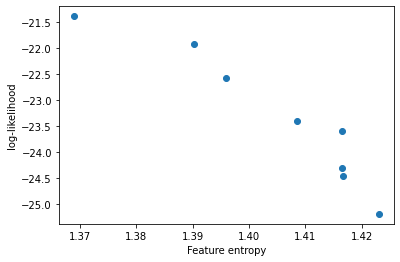

In [120]:
%matplotlib inline
import matplotlib.pyplot as plt

#plt = resultsdf.plot.scatter(x="entropy",y="log-likelihood")
plt.scatter(resultsdf['entropy'],resultsdf['log-likelihood'])
plt.xlabel("Feature entropy")
plt.ylabel("log-likelihood")
#plt.show()
plt.savefig('clustergraph.png',bbox_inches='tight')
plt.show()

In [ ]:
plt.savefig('clustergraph.png')

### We shall now apply K-means to identify the clusters

In [121]:
n = input("How many clusters?")

How many clusters?3


In [122]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=int(n))
c_predicted = km.fit_predict(resultsdf[["log-likelihood","entropy"]])
resultsdf["cluster"]=c_predicted
resultsdf.head()

,length_scale,const,AUC,log-likelihood,entropy,cluster
29,2.430,15.6215,0.998281,-21.382694,1.369002,2
28,2.430,13.8945,0.998281,-21.919729,1.390333,2
27,2.430,12.1675,0.998125,-22.574622,1.396001,0
26,2.430,10.4405,0.997812,-23.394819,1.408616,0
39,3.618,15.6215,0.998281,-23.580365,1.416452,0


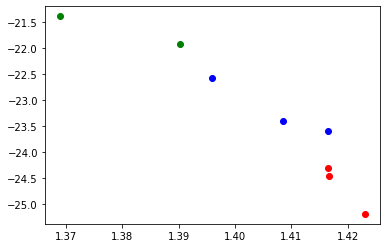

In [123]:
#First create a dictionary for colours:

colour_dict = {
  0: "blue",
  1: "red",
  2: "green",
  3: "cyan",
  4: "magenta",
  5: "yellow",
  6: "black",
}

data_frames = []

for i in range(int(n)):
    data_frames.append(resultsdf[resultsdf.cluster == i])
    plt.scatter(data_frames[i].entropy,data_frames[i]["log-likelihood"],color=colour_dict[i])

#df1 = resultsdf[resultsdf.cluster == 0]
#df2 = resultsdf[resultsdf.cluster == 1]
#df3 = resultsdf[resultsdf.cluster == 2]
#df4 = resultsdf[resultsdf.cluster == 3]

#plt.scatter(df1.entropy,df1["log-likelihood"],color="blue")
#plt.scatter(df2.entropy,df2["log-likelihood"],color="red")
#plt.scatter(df3.entropy,df3["log-likelihood"],color="green")
#plt.scatter(df4.entropy,df4["log-likelihood"],color="black")

In [ ]:
''' It is possible that the user will not be happy with how the data has been assigned.
Offer an option for them to redo the clustering . '''

### We now need to select the median  model (based on entropy) from each of these clusters:

In [124]:
#Lets create a list of models and their accuracies:

models = {}
accuracies = []


#Can't use median function because it finds an average for even sets

for i in range(int(n)):
    index = int(data_frames[i].shape[0]/2)
    observation = data_frames[i].iloc[index]
    #kernel = float(observation['const'])*RBF(float(observation['length_scale']))
    #gp = GaussianProcessClassifier(kernel=kernel,optimizer=None).fit(X, Y)
    models['model{}'.format(i)] = [observation['const'],observation['length_scale']]
    accuracies.append(observation['log-likelihood'])

In [ ]:
#We can pull out the parameters we need

print(models.get("model1")[0])
print(models.get("model1")[1])

In [125]:
# This will be our PIGEBaQ algorithm:

import math

def compute_zn(index,data,output_var,np_lengthscale,np_cov,np_mu):
    x = np.array(data.iloc[[index]])

    element1 = (output_var*math.sqrt(np.linalg.det(np_lengthscale)))/(math.sqrt(np.linalg.det(np_lengthscale+np_cov)))
    element2 = np.linalg.inv(np_lengthscale+np_cov)
    element3 = np.transpose(np_mu - x)
    element4 = -0.5*np.matmul(np.transpose(-1*element3),np.matmul(element2,-1*element3))

    zn = element1*math.exp(element4.item())*np.matmul(element2,element3)
    return zn

def compute_cov(x,y,var,l):  #x and y are each full observations (vectors)
    d = 0
    m = len(x)
    for i in range(m):
        d += (x[i]-y[i])**2
    val = var*np.exp(-0.5*d/(l**2))
    return val


def PIGEBaQ(data,var,length):
    
    this_df = data.dropna()
    this_df.reset_index(drop=True,inplace=True)
    
    mu = list(this_df.mean(axis='index'))
    del mu[-1]
    m = len(mu)
    n = len(this_df.index)
    np_mu = np.array(mu)
    
    this_df2 = this_df.drop(columns=['Output'])
    df_cov = this_df2.cov()
    np_cov = df_cov.to_numpy()
    
    np_lengthscale = length*np.identity(m)
    
    Z = [0]*n
    for i in range(0,n):
        Z[i] = compute_zn(i,this_df2,var,np_lengthscale,np_cov,np_mu)
    
    Z = np.array(Z)
    Z = np.transpose(Z)
    Z = Z.reshape(m,n)
    
    X = this_df2.to_numpy() #Each row is an abservation, each column is a variable
    
    num = this_df2.shape[0]
    K = np.empty([num,num])

    #Now lets start filling this matrix:
    
    for i in range(num):
        for j in range(num):
            K[i,j] = compute_cov(X[i,:],X[j,:],var,length)
    
    f = this_df["Output"].to_numpy()
    f = f.reshape(n)
    
    E = np.matmul(Z,np.matmul(np.linalg.inv(K),f))
    
    output_df = pd.DataFrame({"Skills":this_df2.columns,"Importance":E})
    output_df = output_df.sort_values(by="Importance")
    output_df.reset_index(drop=True, inplace = True)
    
    output_df['Importance'] = output_df['Importance']/math.sqrt(output_df['Importance'].pow(2).sum()) #Normalizes values
    
    return output_df

In [126]:
#input_data_PIG = scaled_total_set.drop(columns=['O*NET-SOC Code', 'Title'])
input_data_PIG = scaled_total_set.copy()

tables = []

for i in range(int(n)):
    tables.append(PIGEBaQ(input_data_PIG,models.get("model{}".format(i))[0],models.get("model{}".format(i))[1]))



In [128]:
tables[1]

,Skills,Importance
0,Feature3,-0.539591
1,Feature1,-0.178142
2,Feature4,-0.136442
3,Feature2,0.811475


In [129]:
#We shall now generate a single dataframe which has the weighted explanations:

explanations_df = pd.DataFrame({"Features":np.array(scaled_total_set.columns[0:4])})
explanations_df["Importance"] = 0.0
#explanations_df

model = tables[0] #This is the relevant importance dataframe

#explanations_df["Importance"][0] = (accuracies[0]/sum(accuracies))*model['Importance'][model.index[model['Skills'] == explanations_df['Features'][0]]]
for j in range(int(n)):
    model = tables[j]
    for i in range(int(explanations_df.shape[0])):
        explanations_df["Importance"][i] += (accuracies[j]/sum(accuracies))*model['Importance'][model.index[model['Skills'] == explanations_df['Features'][i]]]


explanations_df = explanations_df.sort_values(by=["Importance"],ascending=True)
explanations_df.reset_index(drop = True, inplace = True)
explanations_df

 <ipython-input-129-2c5ce980b0df>:13: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Features,Importance
0,Feature3,-0.539591
1,Feature1,-0.178142
2,Feature4,-0.136442
3,Feature2,0.811475


In [ ]:
explanations_df.to_csv("perm_PIGEBaQ.csv",index=False)

In [ ]:
#For the moment, we shall generate an explanation based on feature importance across the different clusters:


tables = []

for i in range(int(n)):
    tables.append(pd.DataFrame({"Features":np.array(training_set.columns[2:37])}))


for i in range(int(n)):
    r = permutation_importance(models[i],X_test,y_test,n_repeats=30,random_state=0)
    #tables[i]["Importances"] = abs(r.importances_mean)
    tables[i]["Importances"] = r.importances_mean
    tables[i] = tables[i].sort_values(by=["Importances"],ascending=False)
    tables[i].reset_index(drop = True, inplace = True)
    
    
    
#for i in range(int(n)):
    #r = permutation_importance(models[i],X_test,y_test,n_repeats=30,random_state=0)
    #importance_table["Importances{}".format(i)] = abs(r.importances_mean)
    #importance_table = importance_table.sort_values(by=['Importances{}'.format(i)])

#NOTE - I'm uneasy about using the same test sets as before, should I expand to the unknown jobs?

importance_dict = {}
for i in range(int(n)):
    q = tables[i]
    importance_dict["Importance{}".format(i)] = q["Features"]
#q = tables[1]
#importance_dict["Importance1"] = q["Features"]
importance_table = pd.DataFrame(data=importance_dict)

In [ ]:
tables[1]

In [ ]:
print(importance_table)

### We now have a table of features sorted by how important they are for each cluster, based on the permutation method

In [ ]:
# We shall generate one more table, which will have a row for each feature and a score for how important it is:

final_importance_table = pd.DataFrame({"Features":np.array(training_set.columns[2:37]),"Importance":np.zeros(np.shape(training_set.columns[2]))})
feature_list = final_importance_table['Features'].tolist()
#final_importance_table.head()
for i in feature_list:
    for j in range(int(n)):
        index_val = importance_table.index[importance_table["Importance{}".format(j)]==i]
        index_val = index_val*accuracies[j]/sum(accuracies)
        final_importance_table.loc[final_importance_table["Features"]==i,"Importance"] += index_val.tolist()[0]
    
final_importance_table = final_importance_table.sort_values(by=["Importance"],ascending=True)
final_importance_table.reset_index(drop = True, inplace = True)
final_importance_table

### We now have a table which ranks features by importance across all the clusters! Note that is values each cluster equally - this might be something we can improve upon

In [ ]:
#Lets divert our attention towards making predictions on our unknown jobs:

unknown_jobs = df4[df4.isna().any(axis=1)] #This is our set of unknown jobs
#SCALE THE DATA! - Do I need to fit a new scaler?
X = scaler.transform(unknown_jobs.iloc[:,2:37])
#X = np.array(unknown_jobs.iloc[:,2:37])
print(X)
#for i in int(n):
    #models[i].predict_proba(X)

In [ ]:
#test = gpc.predict_proba(X)
test1 = gpc.predict(X)
test2 = gpc.predict_proba(X)
print(test1)


In [ ]:
#Now fill in the dataframe:

unknown_jobs["Auto label value"] = test1
unknown_jobs["Auto probability"] = test2[:,1]
unknown_jobs.head()

In [ ]:
unknown_jobs.tail()

In [ ]:
np.shape(test1)

In [ ]:
#Now lets think about how we can apply the model from each of our clusters and compute an average:

for i in range(int(n)):
    probs = models[i].predict_proba(X)
    unknown_jobs["Auto probability{}".format(i)] = probs[:,1]

#We need a list of column titles:
column_titles = []
for i in range(int(n)):
    column_titles.append("Auto probability{}".format(i))

#Now calculate mean automotability    

unknown_jobs["Auto probability"] = unknown_jobs[column_titles].mean(axis=1)

#And finally apply a function to determine auto-label value:

def label_auto(my_input):
    if my_input - 0.5 < 0:
        return 0
    else:
        return 1

unknown_jobs["Auto label value"] = unknown_jobs["Auto probability"].apply(label_auto)

unknown_jobs.head()

In [ ]:
print(unknown_jobs["Title"]["i"])

### We have now generated values for automotability!